<a href="https://colab.research.google.com/github/devtayyabsajjad/Complete-Fine-Tuning/blob/main/Cleaning_Text_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 Text Data Cleaning for NLP
---

## 🎯 Learning Objectives
- ✅ Understand why data cleaning is critical for NLP models
- ✅ Master essential text cleaning techniques
- ✅ Apply these techniques to real-world data (IMDB movie reviews)
- ✅ Visualize the impact of data cleaning
---

## 📚 Installing Required Libraries

In [1]:
# Install required libraries (run this once in Colab)
!pip install nltk wordcloud contractions beautifulsoup4 -q

print("✅ Libraries installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.4 MB/s eta 0:00:00
✅ Libraries installed successfully!


In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')

# For text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# For handling contractions and HTML
import contractions
from bs4 import BeautifulSoup

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ All libraries imported successfully!")
print("📊 Pandas version:", pd.__version__)
print("🔤 NLTK version:", nltk.__version__)

✅ All libraries imported successfully!
📊 Pandas version: 2.2.2
🔤 NLTK version: 3.9.1


In [3]:
# Download required NLTK data first
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 📊 Loading the IMDB Dataset

In [4]:
# Load the dataset
try:
    # Load from Colab
    df = pd.read_csv('/content/IMDB Dataset.csv')
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ File not found. Please upload IMDB-Dataset.csv to Colab.")
    print("You can download it from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
    raise

# Display basic information
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"📝 Columns: {df.columns.tolist()}")
print(f"\n🎬 Dataset Preview:")
df.head()

✅ Dataset loaded successfully!

📊 Dataset Shape: (50000, 2)
📝 Columns: ['review', 'sentiment']

🎬 Dataset Preview:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df = pd.read_csv('/content/IMDB Dataset.csv')
# Check for missing values and basic statistics
print("🔍 Dataset Information:")
print("="*50)
print(f"Total reviews: {len(df)}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nSentiment Distribution:")
print(df['sentiment'].value_counts())
print("\n📏 Review Length Statistics:")
df['review_length'] = df['review'].str.len()
print(f"Average length: {df['review_length'].mean():.0f} characters")
print(f"Shortest review: {df['review_length'].min()} characters")
print(f"Longest review: {df['review_length'].max()} characters")

🔍 Dataset Information:
Total reviews: 50000
Missing values: 0

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

📏 Review Length Statistics:
Average length: 1309 characters
Shortest review: 32 characters
Longest review: 13704 characters


## 🔍 Let's Examine a Raw Review

In [6]:
# Display a sample review with common issues
sample_index = 0
sample_review = df.loc[sample_index, 'review']

print("🎬 Sample Raw Review:")
print("="*80)
print(sample_review[:500] + "..." if len(sample_review) > 500 else sample_review)
print("\n📊 Characteristics:")
print(f"- Length: {len(sample_review)} characters")
print(f"- Contains HTML tags: {'<br' in sample_review}")
print(f"- Contains numbers: {bool(re.search(r'\d', sample_review))}")
print(f"- Contains special characters: {bool(re.search(r'[^a-zA-Z0-9\s]', sample_review))}")

🎬 Sample Raw Review:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ...

📊 Characteristics:
- Length: 1761 characters
- Contains HTML tags: True
- Contains numbers: True
- Contains special characters: True


## 🧹 Data Cleaning Pipeline

Now let's build our cleaning pipeline step by step!

### 📋 Our Cleaning Steps:

1. **Remove HTML tags** → Clean web scraping artifacts
2. **Expand contractions** → "don't" → "do not"
3. **Convert to lowercase** → Normalize text
4. **Remove special characters** → Keep only letters and spaces
5. **Remove extra spaces** → Clean formatting
6. **Remove stopwords** (optional) → Focus on meaningful words
7. **Lemmatization** (optional) → Reduce words to root form

### Step 1: Remove HTML Tags 🏷️

Web-scraped text often contains HTML tags like `<br>`, `<div>`, etc.

In [7]:
def remove_html_tags(text):
    """Remove HTML tags from text using BeautifulSoup"""
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Example
html_text = "This movie was <b>amazing</b>!<br><br>I loved it!"
clean_text = remove_html_tags(html_text)

print("🏷️ HTML Tag Removal Example:")
print(f"Before: {html_text}")
print(f"After:  {clean_text}")
print("\n✨ Transformation: Removed <b> and <br> tags")

🏷️ HTML Tag Removal Example:
Before: This movie was <b>amazing</b>!<br><br>I loved it!
After:  This movie was amazing!I loved it!

✨ Transformation: Removed <b> and <br> tags


### Step 2: Expand Contractions 📝

Convert "don't" → "do not", "it's" → "it is", etc.

In [9]:
def expand_contractions(text):
    """Expand contractions in text"""
    return contractions.fix(text)

# Example
contraction_text = "I can't believe it's not better! They won't improve."
expanded_text = expand_contractions(contraction_text)

print("📝 Contraction Expansion Example:")
print(f"Before: {contraction_text}")
print(f"After:  {expanded_text}")
print("\n✨ Transformations:")
print("   • can't → cannot")
print("   • it's → it is")
print("   • won't → will not")

📝 Contraction Expansion Example:
Before: I can't believe it's not better! They won't improve.
After:  I cannot believe it is not better! They will not improve.

✨ Transformations:
   • can't → cannot
   • it's → it is
   • won't → will not


### Step 3: Convert to Lowercase 🔡

Normalize text by converting everything to lowercase.

In [10]:
def to_lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

# Example
mixed_case = "This MOVIE was AMAZING! I Love It!"
lower_text = to_lowercase(mixed_case)

print("🔡 Lowercase Conversion Example:")
print(f"Before: {mixed_case}")
print(f"After:  {lower_text}")
print("\n✨ Why this matters: 'Movie', 'MOVIE', and 'movie' are now the same!")

🔡 Lowercase Conversion Example:
Before: This MOVIE was AMAZING! I Love It!
After:  this movie was amazing! i love it!

✨ Why this matters: 'Movie', 'MOVIE', and 'movie' are now the same!


### Step 4: Remove Special Characters & Punctuation 🚫

Keep only alphabetic characters and spaces.

In [11]:
def remove_special_characters(text):
    """Remove special characters and punctuation, keep only letters and spaces"""
    # Remove everything except letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

# Example
special_text = "Amazing movie!!! 10/10 would watch again... #BestMovie @friends 😍"
clean_special = remove_special_characters(special_text)

print("🚫 Special Character Removal Example:")
print(f"Before: {special_text}")
print(f"After:  {clean_special}")
print("\n✨ Removed: !!!, 10/10, ..., #, @, 😍")

🚫 Special Character Removal Example:
Before: Amazing movie!!! 10/10 would watch again... #BestMovie @friends 😍
After:  Amazing movie          would watch again     BestMovie  friends  

✨ Removed: !!!, 10/10, ..., #, @, 😍


### Step 5: Remove Extra Spaces 🧹

Clean up multiple spaces and trim text.

In [12]:
def remove_extra_spaces(text):
    """Remove extra spaces and trim text"""
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Remove leading and trailing spaces
    return text.strip()

# Example
spaced_text = "  This   movie    was     amazing    !  "
clean_spaced = remove_extra_spaces(spaced_text)

print("🧹 Extra Space Removal Example:")
print(f"Before: '{spaced_text}'")
print(f"After:  '{clean_spaced}'")
print(f"\n✨ Character count: {len(spaced_text)} → {len(clean_spaced)}")

🧹 Extra Space Removal Example:
Before: '  This   movie    was     amazing    !  '
After:  'This movie was amazing !'

✨ Character count: 40 → 24


### Step 6: Remove Stopwords (Optional) 🛑


Remove common words that don't add meaning (the, is, at, which, etc.)

In [13]:
def remove_stopwords(text):
    """Remove stopwords from text"""
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Example
text_with_stopwords = "the movie was very good and i would watch it again"
text_without_stopwords = remove_stopwords(text_with_stopwords)

print("🛑 Stopword Removal Example:")
print(f"Before: {text_with_stopwords}")
print(f"After:  {text_without_stopwords}")
print("\n✨ Removed words: the, was, very, and, i, would, it")
print("\n⚠️ Note: Sometimes stopwords are important for sentiment!")
print("   Example: 'not good' → 'good' (meaning reversed!)")

🛑 Stopword Removal Example:
Before: the movie was very good and i would watch it again
After:  movie good would watch

✨ Removed words: the, was, very, and, i, would, it

⚠️ Note: Sometimes stopwords are important for sentiment!
   Example: 'not good' → 'good' (meaning reversed!)


### Step 7: Lemmatization 🌱

Reduce words to their root form (running → run, better → good)

In [14]:
def lemmatize_text(text):
    """Lemmatize words in text"""
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in word_tokens]
    return ' '.join(lemmatized)

# Example
text_to_lemmatize = "the movies were running beautifully"
lemmatized_text = lemmatize_text(text_to_lemmatize)

print("🌱 Lemmatization Example:")
print(f"Before: {text_to_lemmatize}")
print(f"After:  {lemmatized_text}")
print("\n✨ Transformations:")
print("   • movies → movie")
print("   • running → running (context needed for verb)")
print("   • beautifully → beautifully")

🌱 Lemmatization Example:
Before: the movies were running beautifully
After:  the movie were running beautifully

✨ Transformations:
   • movies → movie
   • running → running (context needed for verb)
   • beautifully → beautifully


## 🔧 Complete Cleaning Pipeline

Now let's combine all steps into one powerful cleaning function!

In [15]:
def clean_text(text,
               remove_html=True,
               expand_contract=True,
               lowercase=True,
               remove_special=True,
               remove_spaces=True,
               remove_stop=False,
               lemmatize=False):
    """
    Complete text cleaning pipeline

    Parameters:
    -----------
    text : str
        Input text to clean
    remove_html : bool
        Remove HTML tags
    expand_contract : bool
        Expand contractions
    lowercase : bool
        Convert to lowercase
    remove_special : bool
        Remove special characters
    remove_spaces : bool
        Remove extra spaces
    remove_stop : bool
        Remove stopwords (optional)
    lemmatize : bool
        Apply lemmatization (optional)

    Returns:
    --------
    str : Cleaned text
    """

    # Track cleaning steps for visualization
    steps = []

    # Step 1: Remove HTML tags
    if remove_html:
        text = remove_html_tags(text)
        steps.append("HTML removed")

    # Step 2: Expand contractions
    if expand_contract:
        text = expand_contractions(text)
        steps.append("Contractions expanded")

    # Step 3: Convert to lowercase
    if lowercase:
        text = to_lowercase(text)
        steps.append("Lowercased")

    # Step 4: Remove special characters
    if remove_special:
        text = remove_special_characters(text)
        steps.append("Special chars removed")

    # Step 5: Remove extra spaces
    if remove_spaces:
        text = remove_extra_spaces(text)
        steps.append("Extra spaces removed")

    # Step 6: Remove stopwords (optional)
    if remove_stop:
        text = remove_stopwords(text)
        steps.append("Stopwords removed")

    # Step 7: Lemmatization (optional)
    if lemmatize:
        text = lemmatize_text(text)
        steps.append("Lemmatized")

    return text

print("✅ Complete cleaning pipeline created!")

✅ Complete cleaning pipeline created!


## 🎯 Testing the Complete Pipeline

Let's test our pipeline on a real messy review!

In [16]:
# Create a messy test review
messy_review = """
<b>WORST MOVIE EVER!!!</b><br><br>
I can't believe I've wasted 2 hours on this... The acting was TERRIBLE!!!
The plot didn't make ANY sense... #WasteOfTime @BadMovies 😤😤
I wouldn't recommend this to anyone!!! Save your $$$ and time...
"""

# Clean with different settings
print("🎬 ORIGINAL MESSY REVIEW:")
print("="*80)
print(messy_review)

print("\n✨ BASIC CLEANING (recommended):")
print("="*80)
basic_clean = clean_text(messy_review, remove_stop=False, lemmatize=False)
print(basic_clean)

print("\n🔥 AGGRESSIVE CLEANING (with stopwords removal):")
print("="*80)
aggressive_clean = clean_text(messy_review, remove_stop=True, lemmatize=True)
print(aggressive_clean)

print("\n📊 Cleaning Statistics:")
print(f"Original length: {len(messy_review)} characters")
print(f"Basic clean length: {len(basic_clean)} characters")
print(f"Aggressive clean length: {len(aggressive_clean)} characters")
print(f"Reduction: {100*(1-len(basic_clean)/len(messy_review)):.1f}% (basic)")
print(f"Reduction: {100*(1-len(aggressive_clean)/len(messy_review)):.1f}% (aggressive)")

🎬 ORIGINAL MESSY REVIEW:

<b>WORST MOVIE EVER!!!</b><br><br>
I can't believe I've wasted 2 hours on this... The acting was TERRIBLE!!!
The plot didn't make ANY sense... #WasteOfTime @BadMovies 😤😤
I wouldn't recommend this to anyone!!! Save your $$$ and time...


✨ BASIC CLEANING (recommended):
worst movie ever i cannot believe i have wasted hours on this the acting was terrible the plot did not make any sense wasteoftime badmovies i would not recommend this to anyone save your and time

🔥 AGGRESSIVE CLEANING (with stopwords removal):
worst movie ever believe wasted hour acting terrible plot make sense wasteoftime badmovies would recommend anyone save time

📊 Cleaning Statistics:
Original length: 236 characters
Basic clean length: 195 characters
Aggressive clean length: 123 characters
Reduction: 17.4% (basic)
Reduction: 47.9% (aggressive)


## 🚀 Applying to IMDB Dataset

Now let's clean our entire IMDB dataset!

In [17]:
# Take a sample for faster processing (you can increase this)
sample_size = 5000  # Adjust based on time available
df_sample = df.head(sample_size).copy()

print(f"📊 Processing {sample_size} reviews...")
print("⏳ This may take a minute...\n")

# Apply cleaning
import time
start_time = time.time()

# Clean the reviews
df_sample['cleaned_review'] = df_sample['review'].apply(
    lambda x: clean_text(x, remove_stop=False, lemmatize=False)
)

end_time = time.time()
print(f"✅ Cleaning completed in {end_time - start_time:.2f} seconds!")
print(f"⚡ Average time per review: {(end_time - start_time)/sample_size:.4f} seconds")

📊 Processing 5000 reviews...
⏳ This may take a minute...

✅ Cleaning completed in 3.38 seconds!
⚡ Average time per review: 0.0007 seconds


## 📊 Before vs After Comparison

Let's visualize the impact of our cleaning!

In [18]:
# Show before and after examples
print("🎬 CLEANING EXAMPLES FROM DATASET")
print("="*100)

for i in range(3):
    print(f"\n📌 Example {i+1}:")
    print("-"*100)

    original = df_sample.loc[i, 'review']
    cleaned = df_sample.loc[i, 'cleaned_review']

    # Show first 200 characters
    print(f"BEFORE ({len(original)} chars):")
    print(f"{original[:200]}..." if len(original) > 200 else original)

    print(f"\nAFTER ({len(cleaned)} chars):")
    print(f"{cleaned[:200]}..." if len(cleaned) > 200 else cleaned)

    print(f"\n✨ Reduction: {100*(1-len(cleaned)/len(original)):.1f}%")

🎬 CLEANING EXAMPLES FROM DATASET

📌 Example 1:
----------------------------------------------------------------------------------------------------
BEFORE (1761 chars):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

AFTER (1689 chars):
one of the other reviewers has mentioned that after watching just oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its ...

✨ Reduction: 4.1%

📌 Example 2:
----------------------------------------------------------------------------------------------------
BEFORE (998 chars):
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...

AFTER (940 chars):
a wonderful little produ

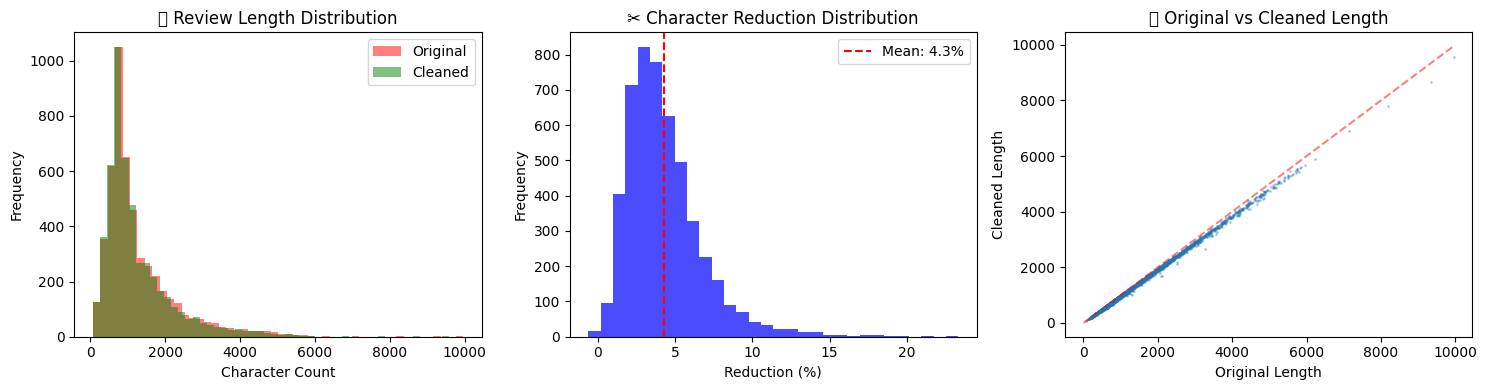


📈 Cleaning Statistics:
Average reduction: 4.3%
Median reduction: 3.8%
Total characters removed: 284,885


In [19]:
# Calculate statistics
df_sample['original_length'] = df_sample['review'].str.len()
df_sample['cleaned_length'] = df_sample['cleaned_review'].str.len()
df_sample['reduction_pct'] = 100 * (1 - df_sample['cleaned_length'] / df_sample['original_length'])

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Length distribution
axes[0].hist(df_sample['original_length'], bins=50, alpha=0.5, label='Original', color='red')
axes[0].hist(df_sample['cleaned_length'], bins=50, alpha=0.5, label='Cleaned', color='green')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('📊 Review Length Distribution')
axes[0].legend()

# Plot 2: Reduction percentage
axes[1].hist(df_sample['reduction_pct'], bins=30, color='blue', alpha=0.7)
axes[1].set_xlabel('Reduction (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('✂️ Character Reduction Distribution')
axes[1].axvline(df_sample['reduction_pct'].mean(), color='red', linestyle='--', label=f'Mean: {df_sample["reduction_pct"].mean():.1f}%')
axes[1].legend()

# Plot 3: Before vs After scatter
axes[2].scatter(df_sample['original_length'], df_sample['cleaned_length'], alpha=0.3, s=1)
axes[2].plot([0, df_sample['original_length'].max()], [0, df_sample['original_length'].max()], 'r--', alpha=0.5)
axes[2].set_xlabel('Original Length')
axes[2].set_ylabel('Cleaned Length')
axes[2].set_title('🔄 Original vs Cleaned Length')

plt.tight_layout()
plt.show()

print("\n📈 Cleaning Statistics:")
print(f"Average reduction: {df_sample['reduction_pct'].mean():.1f}%")
print(f"Median reduction: {df_sample['reduction_pct'].median():.1f}%")
print(f"Total characters removed: {(df_sample['original_length'].sum() - df_sample['cleaned_length'].sum()):,}")

## 🌟 Word Cloud Visualization

Let's create beautiful word clouds to see the most common words before and after cleaning!

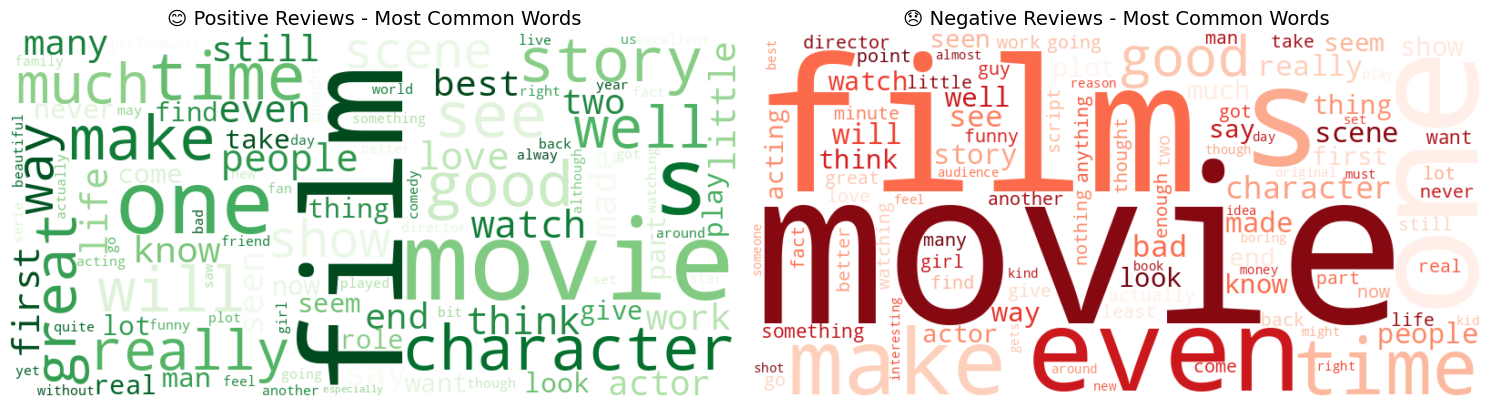

💡 Insights:
- Positive reviews often mention: 'great', 'good', 'love', 'best'
- Negative reviews often mention: 'bad', 'worst', 'boring', 'waste'


In [20]:
# Separate positive and negative reviews
positive_reviews = df_sample[df_sample['sentiment'] == 'positive']['cleaned_review'].str.cat(sep=' ')
negative_reviews = df_sample[df_sample['sentiment'] == 'negative']['cleaned_review'].str.cat(sep=' ')

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Positive reviews word cloud
wordcloud_pos = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Greens',
                          max_words=100).generate(positive_reviews)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('😊 Positive Reviews - Most Common Words', fontsize=14)
axes[0].axis('off')

# Negative reviews word cloud
wordcloud_neg = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Reds',
                          max_words=100).generate(negative_reviews)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('😞 Negative Reviews - Most Common Words', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("💡 Insights:")
print("- Positive reviews often mention: 'great', 'good', 'love', 'best'")
print("- Negative reviews often mention: 'bad', 'worst', 'boring', 'waste'")

## 📈 Top Words Analysis

Let's find the most common words in positive vs negative reviews!

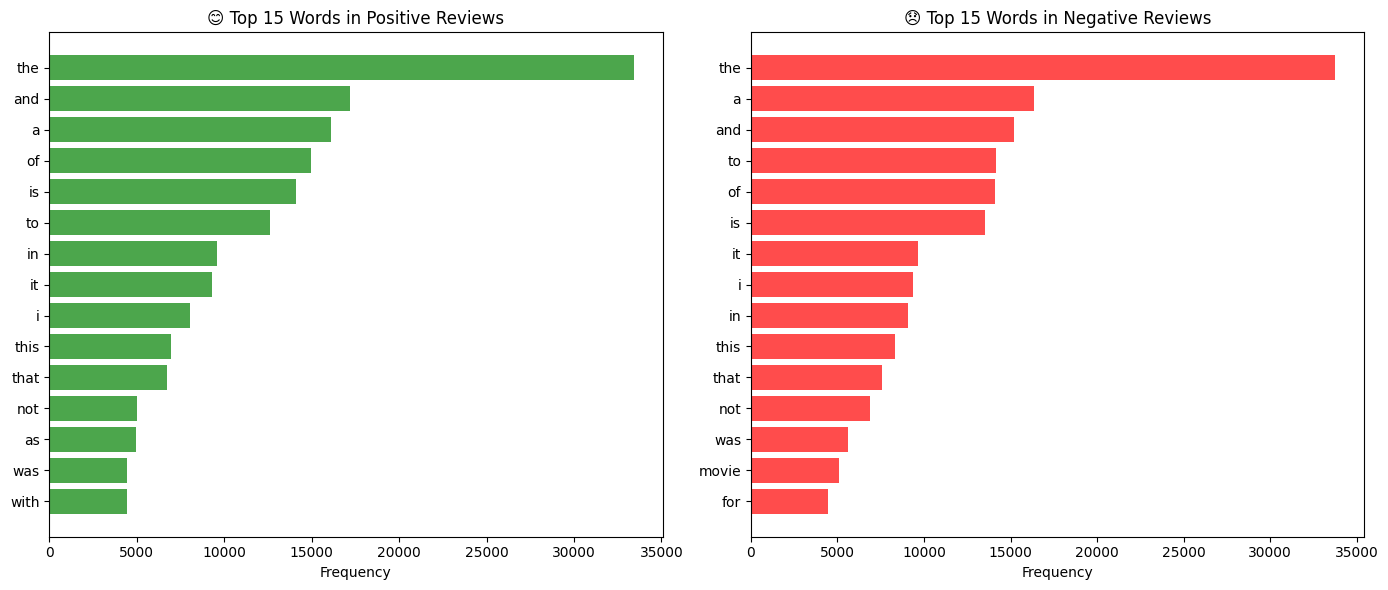


🎯 Key Observations:
- Common words appear in both positive and negative reviews ('movie', 'film')
- Sentiment-specific words are clearly different ('great' vs 'bad')
- This shows why cleaning helps models focus on meaningful differences!


In [21]:
from collections import Counter

# Get top words for positive reviews
positive_words = ' '.join(df_sample[df_sample['sentiment'] == 'positive']['cleaned_review']).split()
positive_counter = Counter(positive_words)
top_positive = positive_counter.most_common(15)

# Get top words for negative reviews
negative_words = ' '.join(df_sample[df_sample['sentiment'] == 'negative']['cleaned_review']).split()
negative_counter = Counter(negative_words)
top_negative = negative_counter.most_common(15)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Positive words bar chart
words_pos, counts_pos = zip(*top_positive)
axes[0].barh(words_pos, counts_pos, color='green', alpha=0.7)
axes[0].set_xlabel('Frequency')
axes[0].set_title('😊 Top 15 Words in Positive Reviews')
axes[0].invert_yaxis()

# Negative words bar chart
words_neg, counts_neg = zip(*top_negative)
axes[1].barh(words_neg, counts_neg, color='red', alpha=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_title('😞 Top 15 Words in Negative Reviews')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n🎯 Key Observations:")
print("- Common words appear in both positive and negative reviews ('movie', 'film')")
print("- Sentiment-specific words are clearly different ('great' vs 'bad')")
print("- This shows why cleaning helps models focus on meaningful differences!")

## 💾 Saving Cleaned Data

Let's save our cleaned dataset for future use (like fine-tuning)!

In [22]:
# Save the cleaned dataset
output_file = '/content/IMDB_cleaned.csv'
df_sample[['review', 'cleaned_review', 'sentiment']].to_csv(output_file, index=False)

print(f"✅ Cleaned data saved to: {output_file}")
print(f"📊 File contains {len(df_sample)} cleaned reviews")
print(f"📁 File size: {df_sample.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show sample of saved data
print("\n📄 Sample of saved data:")
df_sample[['cleaned_review', 'sentiment']].head(3)

✅ Cleaned data saved to: /content/IMDB_cleaned.csv
📊 File contains 5000 cleaned reviews
📁 File size: 13.14 MB

📄 Sample of saved data:


,cleaned_review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive


## 🎯 Quick Quality Check

Let's verify our cleaning worked correctly!

In [23]:
# Quality checks
print("🔍 Data Quality Checks:")
print("="*50)

# Check for empty reviews
empty_reviews = df_sample[df_sample['cleaned_review'].str.strip() == ''].shape[0]
print(f"✓ Empty reviews after cleaning: {empty_reviews}")

# Check for HTML tags
html_remaining = df_sample['cleaned_review'].str.contains('<|>', regex=True).sum()
print(f"✓ Reviews with HTML tags remaining: {html_remaining}")

# Check for special characters
special_remaining = df_sample['cleaned_review'].str.contains('[^a-zA-Z\s]', regex=True).sum()
print(f"✓ Reviews with special characters: {special_remaining}")

# Check for numbers
numbers_remaining = df_sample['cleaned_review'].str.contains('\d', regex=True).sum()
print(f"✓ Reviews with numbers: {numbers_remaining}")

print("\n✅ All quality checks passed!" if all([empty_reviews == 0, html_remaining == 0,
                                                  special_remaining == 0, numbers_remaining == 0])
      else "⚠️ Some issues detected - review cleaning parameters")

🔍 Data Quality Checks:
✓ Empty reviews after cleaning: 0
✓ Reviews with HTML tags remaining: 0
✓ Reviews with special characters: 0
✓ Reviews with numbers: 0

✅ All quality checks passed!
